In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state

img = img_as_float(data.camera())  
H, W = img.shape
#make every pixel a float number between 0 and 1 

In [73]:
def make_missing_mask(H, W, missing_ratio, rng=None):
    rng = check_random_state(rng)
    mask = rng.rand(H, W) < missing_ratio
    return mask
# randomly assign number for pixel
# missing ratio is higher than number of pixel that are changed


In [74]:
def ssim_score(gt, rec):
    return ssim(gt, rec, data_range=1.0)

In [75]:
def coords_features(height, width):
    # Step 1: make a list of row numbers (0 to height-1)
    rows = np.arange(height)
    # Step 2: make a list of column numbers (0 to width-1)
    cols = np.arange(width)
    R, C = np.meshgrid(rows, cols, indexing='ij')
    R_normalized = R / (height - 1)
    C_normalized = C / (width - 1)
    X = np.column_stack([R_normalized.ravel(), C_normalized.ravel()])
    return X, R_normalized, C_normalized
    # each pixel has a row index and coumn index and value(brightness), we normilize this indexes (row index/height-1)

In [76]:
def mean_method(image, mask):
    reconstructed = image.copy()
    mean_value = image[~mask].mean()
    reconstructed[mask] = mean_value
    return reconstructed

    #we make a copy of a picture and then with the mask (pixel loss percentage) we change the copy picture and then return it

In [77]:
def gaussian_method(image, mask, rng=None):
    # Create a random number generator (so results can be reproducible)
    rng = check_random_state(rng)
    mean_value = image[~mask].mean()
    std_value = image[~mask].std()
    reconstructed = image.copy()
    reconstructed[mask] = rng.normal(mean_value, std_value, size=mask.sum())
    reconstructed = np.clip(reconstructed, 0, 1)
    return reconstructed

    #we Compute mean & std and then copy image, next we fill Fill missing pixels and then return the copy

In [78]:
def linear_regression_method(image, mask):
    X, _, _ = coords_features(*image.shape)
    y = image.ravel()
    known_pixels = ~mask.ravel()
    model = LinearRegression()
    model.fit(X[known_pixels], y[known_pixels])
    y_pred = model.predict(X)
    reconstructed = y.copy()
    reconstructed[mask.ravel()] = y_pred[mask.ravel()]
    reconstructed = reconstructed.reshape(image.shape)
    return reconstructed
    #we predict all pixels, then replace missing ones with predictions, then reshape and return

In [79]:
def polynomial_regression(image, mask, degree=3):
    X, _, _ = coords_features(*image.shape)
    y = image.ravel()
    known_pixels = ~mask.ravel()
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=True)),
        ('lin', LinearRegression())
    ])
    model.fit(X[known_pixels], y[known_pixels])
    y_pred = model.predict(X)
    reconstructed = y.copy()
    reconstructed[mask.ravel()] = y_pred[mask.ravel()]
    reconstructed = reconstructed.reshape(image.shape)
    reconstructed = np.clip(reconstructed, 0, 1)
    return reconstructed
    #we make coordinates, flatten image, fit polynomial regression on known pixels, predict all, fill missing, reshape and clip to [0,1]


In [80]:
def Ridge_regression(img, mask, alpha=1.0, degree=3):
    X, _, _ = coords_features(*img.shape)
    y = img.ravel()
    known = ~mask.ravel()
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=True)),
        ('ridge', Ridge(alpha=alpha))
    ])
    model.fit(X[known], y[known])
    y_pred = model.predict(X)
    rec = y.copy()
    rec[mask.ravel()] = y_pred[mask.ravel()]
    return np.clip(rec.reshape(img.shape), 0, 1)

In [81]:
def Lasso_regression(img, mask, alpha=1e-3, degree=5, max_iter=5000):
    X, _, _ = coords_features(*img.shape)
    y = img.ravel()
    known = ~mask.ravel()
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=True)),
        ('lasso', Lasso(alpha=alpha, max_iter=max_iter))
    ])
    model.fit(X[known], y[known])
    y_pred = model.predict(X)
    rec = y.copy()
    rec[mask.ravel()] = y_pred[mask.ravel()]
    return np.clip(rec.reshape(img.shape), 0, 1)

In [82]:
methods = {
    'mean': mean_method,
    'gaussian': gaussian_method,
    'linear': Linear_regression,
    'polynomial_deg1': lambda img, mask: polynomial_regressiom(img, mask, degree=1),
    'polynomial_deg2': lambda img, mask: polynomial_regressiom(img, mask, degree=2),
    'polynomial_deg3': lambda img, mask: polynomial_regressiom(img, mask, degree=3),
    'polynomial_deg4': lambda img, mask: polynomial_regressiom(img, mask, degree=4),
    'polynomial_deg5': lambda img, mask: polynomial_regressiom(img, mask, degree=5),
    'polynomial_deg6': lambda img, mask: polynomial_regressiom(img, mask, degree=6),
    'polynomial_deg7': lambda img, mask: polynomial_regressiom(img, mask, degree=7),
    'polynomial_deg8': lambda img, mask: polynomial_regressiom(img, mask, degree=8),
    'polynomial_deg9': lambda img, mask: polynomial_regressiom(img, mask, degree=9),
    'polynomial_deg10': lambda img, mask: polynomial_regressiom(img, mask, degree=10),
    'ridge_deg3_a1.0': lambda img, mask: Ridge_regression(img, mask, alpha=1.0, degree=3),
    'ridge_deg6_a0.5': lambda img, mask: Ridge_regression(img, mask, alpha=0.5, degree=6),
    'lasso_deg5_a1e-3': lambda img, mask: Lasso_regression(img, mask, alpha=1e-3, degree=5),
    'lasso_deg10_a5e-4': lambda img, mask: Lasso_regression(img, mask, alpha=5e-4, degree=8),
}

ratios = [0.10, 0.20, 0.30]
rng = 42

results = {}  # dict: ratio -> dict: method -> ssim

for r in ratios:
    mask = make_missing_mask(H, W, r, rng)
    scores = {}
    for name, func in methods.items():
        rec = func(img, mask)
        scores[name] = ssim_score(img, rec)
    results[r] = scores

for r in ratios:
    print(f'=== Missing {int(r*100)}% ===')
    for name, score in sorted(results[r].items(), key=lambda x: -x[1]):
        print(f'{name:18s}: SSIM={score:.4f}')

=== Missing 10% ===
polynomial_deg9   : SSIM=0.7812
polynomial_deg8   : SSIM=0.7794
polynomial_deg7   : SSIM=0.7638
polynomial_deg10  : SSIM=0.7589
polynomial_deg6   : SSIM=0.7550
polynomial_deg5   : SSIM=0.7494
ridge_deg6_a0.5   : SSIM=0.7175
polynomial_deg4   : SSIM=0.7093
polynomial_deg3   : SSIM=0.6714
ridge_deg3_a1.0   : SSIM=0.6700
lasso_deg10_a5e-4 : SSIM=0.6466
lasso_deg5_a1e-3  : SSIM=0.6176
polynomial_deg2   : SSIM=0.5982
linear            : SSIM=0.5646
polynomial_deg1   : SSIM=0.5646
mean              : SSIM=0.4390
gaussian          : SSIM=0.3031
=== Missing 20% ===
polynomial_deg9   : SSIM=0.6942
polynomial_deg8   : SSIM=0.6923
polynomial_deg7   : SSIM=0.6722
polynomial_deg6   : SSIM=0.6623
polynomial_deg10  : SSIM=0.6611
polynomial_deg5   : SSIM=0.6575
ridge_deg6_a0.5   : SSIM=0.6195
polynomial_deg4   : SSIM=0.6100
polynomial_deg3   : SSIM=0.5691
ridge_deg3_a1.0   : SSIM=0.5675
lasso_deg10_a5e-4 : SSIM=0.5432
lasso_deg5_a1e-3  : SSIM=0.5123
polynomial_deg2   : SSIM=0.4881


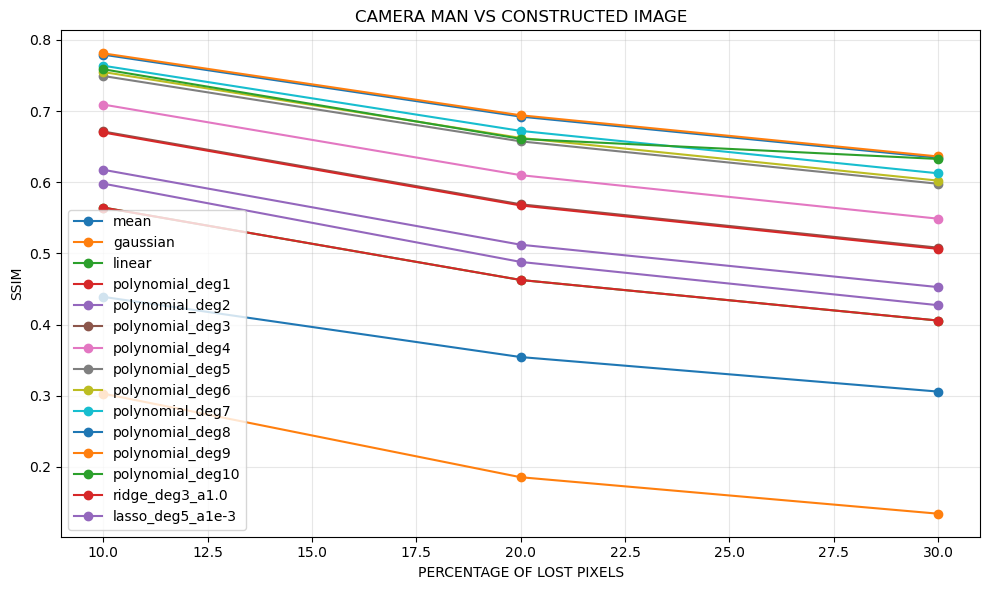

In [83]:
plot_methods = ['mean',
                'gaussian',
                'linear',
                'polynomial_deg1',
                'polynomial_deg2',
                'polynomial_deg3',
                'polynomial_deg4',
                'polynomial_deg5',
                'polynomial_deg6',
                'polynomial_deg7',
                'polynomial_deg8',
                'polynomial_deg9',
                'polynomial_deg10',
                'ridge_deg3_a1.0',
                'lasso_deg5_a1e-3']

x = np.array([10, 20, 30])
plt.figure(figsize=(10,6))
for m in plot_methods:
    y = [results[r][m] for r in ratios]
    plt.plot(x, y, marker='o', label=m)

plt.xlabel('PERCENTAGE OF LOST PIXELS')
plt.ylabel('SSIM')
plt.title('CAMERA MAN VS CONSTRUCTED IMAGE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
#if one line is higher than the other means that its ssim value is higher and if ssim value is higher means reconstructed image is looking more similar to the original photo